# <div align="center"> CNN可视化: Gradient-weighted Class Activation Mapping (Grad-CAM) </div>

## 导图

### 论文树图

In [28]:
from IPython.display import display, HTML
from urllib import parse
from graphviz import Source
graph = '''digraph G {
    center = true  
    fontsize = 18  fontcolor = "#00000000"
    labelloc = top  labeljust = center
    label = "Post-Hoc Attention"
    node [shape=rectangle, color=dodgerblue]
    a [label="Guided Backpropagation [2015]"]
    b [label="CAM [2016]"]
    c [label="Grad-CAM [2017]", style=filled]
    d [label="Guided Grad-CAM [2017]"]
    e [label="Guided Grad-CAM++ [2018]"]
    f [label="GAIN [2018]"]
    
    a -> d
    b -> c
    c -> d
    d -> e
    d -> f
}'''
# Source(graph)
HTML('<img src="data:image/svg+xml;utf8,{}"/>'.format(parse.quote(Source(graph)._repr_svg_())))

### 模型框架简图

In [29]:
graph = '''digraph G {
    fontsize = 12
    labelloc = top  labeljust = center
    rankdir = LR ranksep = 0.2
    compound = true
    node[shape=box style=rounded]
    subgraph cluster_cnn {
        penwidth = 0
        label = "Feature Extractor"
        a [label="" shape=box style=rounded]
        b [label="" shape=box style=rounded]
        c [label="..." shape=none]
        subgraph cluster_0 {
            penwidth = 1
            rankdir = TB
            style="dashed, rounded"
            node[shape=box style=rounded]
            A1 [color="red"]
            A2 [color="green"]
            A3 [color="blue"]
            label = "conv layer"
        }
    }
    subgraph cluster_clf {
        penwidth = 0
        label = "Classifier"
        subgraph cluster_1 {
            penwidth = 1
            rankdir = TB
            style="dashed, rounded"
            node[shape=box style=rounded]
            W1 [color="red"]
            W2 [color="green"]
            W3 [color="blue"]
            label = "fc layer"
        }
    }
    d [label="any layers" shape=none fontcolor="#ffaaaa" fontsize=16]
    a -> b [label="conv"]
    b -> c [label="conv"]
    c -> A2 [lhead=cluster_0 label="conv"]
    A2 -> d [ltail=cluster_0] 
    d -> W2 [lhead=cluster_1]
}'''
HTML('<img src="data:image/svg+xml;utf8,{}"/>'.format(parse.quote(Source(graph)._repr_svg_())))

## 描述

相比CAM只能应用在特殊网络模型(Conv -> GAP -> LC)结构上的缺陷, Grad-CAM(梯度加权类激活热图)没有这个限制, 只要是基于CNN的模型框架都可以适用, 但是, 因为是基于梯度的方式(Gradient Weights), 所以最后的卷积层连接的网络层(包括激活函数)是可微的. CAM可看做Grad-CAM的一个特例(fully convolutional), Grad-CAM更具有一般性. 

Grad-CAM和CAM在热图效果上是相似的. 经过更深层的CNN后, 将会提取更高层次的视觉结构(语义),并且天然地保存了空间信息(而在FC层这些信息会丢失), CAM是通过最后的Conv特征和FC的权重线性组合而实现, 丢失一些空间信息, Grad-CAM则是通过最后的Conv特征和特征梯度信息(作为权重)组合而实现, CAM根据最后分类器LC的权重组合最后一层的特征图, Grad-CAM则先反向传播计算出最后特征图的梯度, 梯度在经过GAP求平均得到$alpha$作为与最后一层特征图的权重, 梯度权重$alpha$与特征图A线性组合后, 应用LeRU进行矫正变换, 将对目标分类有正效应(>0)的留下(正值), 负效应的值清除. 

Grad-CAM可以用来理解模型对目标类预测过程, 分类对象的关键部分的定位(显著特征).

理论上可以对每一个卷积层做Grad-CAM.

## 模型

![](https://gitee.com/qrsforever/blog_source_assets/raw/master/AI/post-hoc/grad-cam.png)

$$
\begin{align*}
L_{Grad-CAM}^c &= ReLU\big( \sum_{k}^K \alpha_k^c A^k \big) \\
\alpha_k^c &= \dfrac{1}{Z} \sum_i^u \sum_j^v \dfrac{\partial y^c}{\partial {A_{ij}^c}}
\end{align*}
$$

符号|描述
:--:|:----
<img width=200/>|<img width=400/>
A|特征图(feature map)
K|卷积的特征图的数目(number of feature maps)
u|特征图的宽(width)
v|特征图的高(height)
Z|Z = u*v 表示特征图的像素数 $\sum_{i=1}^{u}\sum_{j=1}^{v} 1$
c|分类类别值(如:Australian terrier)
$y^c$|c分类分数值(classification scores)
$\alpha_k^c$|对特征梯度均值化后, 作为特征A的权重 (梯度权重)
$L_{Grad-CAM}^c$|加权梯度CAM目标分类位置热图

## 代码演示

### 导入库

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import os, io
import numpy as np
import torch
import torchvision
import PIL
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from torchvision import transforms, models
from torch.nn import functional as F
from PIL import Image
from matplotlib.pyplot import imshow
from IPython.display import display, HTML

In [5]:
np.__version__, torch.__version__, torchvision.__version__, PIL.__version__

('1.18.2', '1.5.0.dev20200319', '0.6.0.dev20200319', '7.0.0')

### 加载图片

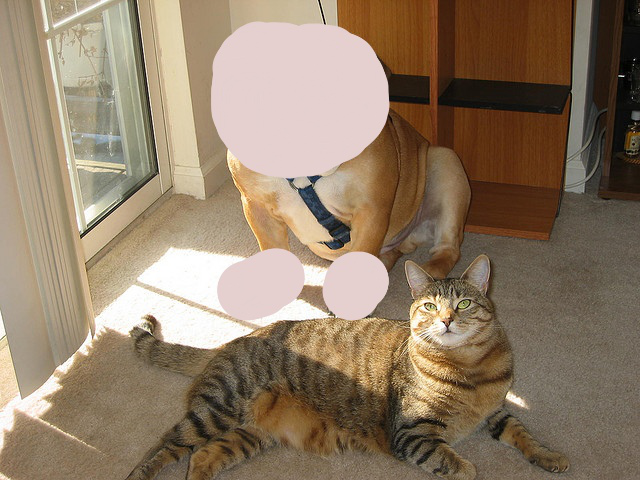

(640, 480, 'RGB')

In [6]:
image_path = os.path.join('../../', 'assets', 'cat_dog.jpg')
# image_path = os.path.join('../../', 'assets', 'cat_dog_cover.jpg')
image_raw = Image.open(image_path).convert('RGB')
display(image_raw)
image_raw.width, image_raw.height, image_raw.mode

### 数据增强

In [7]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
])

inputs = transform(image_raw).unsqueeze(0)
inputs.shape

torch.Size([1, 3, 224, 224])

### 加载模型并注册hooks

In [21]:
model = models.resnet18(pretrained=True)
print(model)

candidate_layers = ['layer4']

fmap_pool = {}
grad_pool = {}

def save_fmaps(key):
    def forward_hook(module, _, output):
        fmap_pool[key] = output.detach()
    return forward_hook

def save_grads(key):
    def backward_hook(module, grad_in, grad_out):
        grad_pool[key] = grad_out[0].detach()
    return backward_hook
        
## 注册features map提取hook,以及梯度hook
handle_hooks = []
for name, module in model.named_modules():
    if name in candidate_layers:
        handle_hooks.append(module.register_forward_hook(save_fmaps(name)))
        handle_hooks.append(module.register_backward_hook(save_grads(name)))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 获取卷积特征forward

In [9]:
model.eval()
out = model(inputs)
print(out.size())

# feature map
feature_map = fmap_pool[candidate_layers[0]]
feature_map.size()

torch.Size([1, 1000])


torch.Size([1, 512, 7, 7])

### 反向计算梯度backward

In [16]:
top3 = torch.topk(out, 3) # 242:dog 282:cat
print(top3)
target_idx = top3[1][0][0].item()

def obtain_gradient(idx):
    # one hot encoder
    one_hot = torch.zeros_like(out)
    one_hot.scatter_(1, torch.tensor([[idx]],dtype=torch.int64), 1.0)

    # gradient
    out.backward(gradient=one_hot, retain_graph=True)
    return grad_pool[candidate_layers[0]]

gradients = obtain_gradient(target_idx)
gradients.shape

torch.return_types.topk(
values=tensor([[14.6057, 13.4177, 12.3664]], grad_fn=<TopkBackward>),
indices=tensor([[282, 281, 285]]))


torch.Size([1, 512, 7, 7])

### 计算Alphas


$$
\alpha_k^c = \dfrac{1}{Z} \sum_{i}^{u} \sum_{j}^{v} \dfrac{\partial {y^c}}{\partial {A_{ij}^k}}
$$

In [17]:
# Alphas Averaging Gradients
alphas = F.adaptive_avg_pool2d(gradients, 1)
gradients.shape, alphas.shape, feature_map.shape

(torch.Size([1, 512, 7, 7]),
 torch.Size([1, 512, 1, 1]),
 torch.Size([1, 512, 7, 7]))

### 计算Grad-CAM

$$
L_{Grad-CAM}^c = ReLU\big( \sum_{k}^K \alpha_k^c A^k \big)
$$

In [18]:
gcam = torch.mul(feature_map, alphas).sum(dim=1, keepdim=True)

# RELU:加强正影响(对目标类), 削弱负影响(其他分类)
gcam = F.relu(gcam)
gcam.shape

torch.Size([1, 1, 7, 7])

### 可视化Grad-CAM

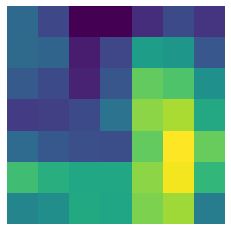

In [19]:
gcam_np = gcam.cpu().numpy()[0, 0, ...]
gcam_np -= np.min(gcam_np)
gcam_np /= np.max(gcam_np)
plt.axis("off")
imshow(np.uint8(gcam_np * 255));

### 渲染Grad-CAM覆盖图

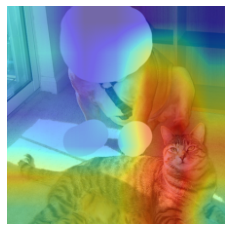

In [20]:
plt.axis("off")
image_trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
])
imshow(image_trans(image_raw))
imshow(Image.fromarray(np.uint8(gcam_np*255)).resize((224, 224), Image.BILINEAR), alpha=0.5, cmap='jet');

## 参考 

- [论文:“Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization.” International Journal of Computer Vision 2019](https://arxiv.org/pdf/1610.02391.pdf)

- [Grad-CAM](https://glassboxmedicine.com/2020/05/29/grad-cam-visual-explanations-from-deep-networks/)

- [Gradient-weighted Class Activation Mapping(Grad-CAM)](https://medium.com/@mohamedchetoui/grad-cam-gradient-weighted-class-activation-mapping-ffd72742243a)

- [Pytorch: Grad-CAM](https://github.com/kazuto1011/grad-cam-pytorch)

非事实解释（Counterfactual Explanations）

讲一个有意思的场景。假设我想去贷款，然后被银行的机器学习模型拒绝了。我会想，为什么我会被拒绝，以及如何能提高我被接受的概率。机器学习模型用到的特征包括，我自身的属性，包括收入，银行卡数量，年龄等。如何对这些特征做出最小的改变，使得模型的预测从拒绝变成接受呢。通过构建违反常规的样本，来改变模型的预测，从而达到对模型进行可解释的目的。

类似在风控任务中，为什么这个人违约率高。如果，对其修改某个特征后，概率会降低。这样可以解释，是因为某个特征值，模型预测的概率比较高。

如何定义一个好的非事实解释：

    尽可能和想要的预测更接近；
    对于特征值进行尽可能少的改变；
    修改后的特征值尽可能符合实际情况；